### Encoder

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
gpu = tf.config.get_visible_devices("GPU")
tf.config.experimental.set_memory_growth(gpu[0],True)

In [3]:
# dimensionality reduction: 2D plane
latent_dim = 2

In [4]:
encoder_inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(32,3,activation = "relu",strides = 2, padding="same")(encoder_inputs)
x = layers.Conv2D(64,3,activation = "relu",strides = 2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16,activation="relu")(x)
z_mean = layers.Dense(latent_dim,name="z_mean")(x)
z_log_var = layers.Dense(latent_dim,name="z_log_var")(x)
encoder = keras.Model(encoder_inputs,[z_mean,z_log_var], name="encoder")


In [5]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

### Sampling Layer:

In [6]:
import tensorflow as tf

In [7]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Drawing a batch of normal random vectors:
        epsilon = tf.random.normal(shape=(batch_size,z_size))
        # VAE sampling formula:
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Decoder:

In [8]:
# INput where z will be fed: z --> latent point (vecotr)
latent_inputs = keras.Input(shape=(latent_dim,))
# To produce the same number of co-efficients that we had at the level of the flatten layer in the encoder:
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Reverting the flatten layer:
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding = "same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

### VAE Model:

In [15]:
mnist_digits[0].shape

(28, 28, 1)

In [17]:
x = np.expand_dims(mnist_digits[0], axis=0)
x.shape

(1, 28, 28, 1)

In [18]:
z_mean, z_log_var = encoder.predict(x)

1/1 [==============================] - 0s 180ms/step


In [21]:
latent_vector  = Sampler().call(z_mean,z_log_var)

In [23]:
reconstructed_image = decoder.predict(latent_vector)

1/1 [==============================] - 0s 427ms/step


In [22]:
print(f'{z_mean}')
print(f'{z_log_var}')
print(f"{latent_vector}")

[[-0.03160293  0.14434938]]
[[ 0.03122083 -0.04430886]]
[[ 1.2163095 -1.3669114]]


In [24]:
reconstructed_image.shape

(1, 28, 28, 1)

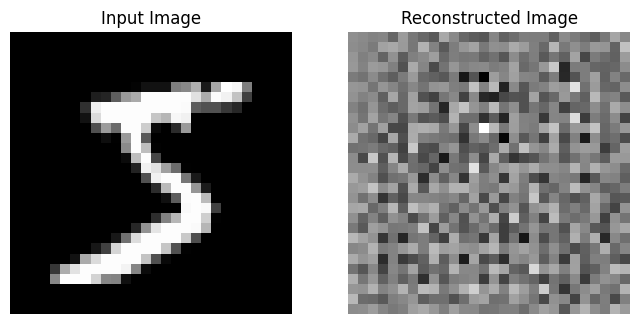

In [28]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(x.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()

In [10]:
# Defining a custom keras model called VAE:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        # calling the constructor of the parent class:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    # @property a decorator in python used for defining properties of class , truns functions to attributes:
    @property
    # custom metrics:
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    # A single training step is defined for the VAE model:
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var =self.encoder(data)
            z = self.sampler(z_mean,z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
# this line learns the KL divergence loss:
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # total loss which is the sum of kl loss and reconstruction loss:
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
# This line computes the gradients of the total loss with respect to the the trainable weights of the model:
            grads = tape.gradient(total_loss, self.trainable_weights)
            # This line applies the the gradients to update the model's weight using the specified optimizer, when compiling the model:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
#  The following lines update teh state of the loss trackers with the computerd loss
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)

            return {
                "total_loss" : self.total_loss_tracker.result(),
                "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
                "kl_loss" : self.kl_loss_tracker.result()
            }

### Training VAE:

In [10]:
import numpy as np
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train, -1).astype("float32") / 255

In [12]:
vae = VAE(encoder=encoder, decoder=decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

In [13]:
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 16s 30ms/step - total_loss: 217.0081 - reconstruction_loss: 214.6643 - kl_loss: 2.3425
Epoch 2/30
469/469 [==============================] - 14s 30ms/step - total_loss: 173.4995 - reconstruction_loss: 169.4339 - kl_loss: 4.0657
Epoch 3/30
469/469 [==============================] - 14s 30ms/step - total_loss: 165.9456 - reconstruction_loss: 162.1929 - kl_loss: 3.7526
Epoch 4/30
469/469 [==============================] - 14s 29ms/step - total_loss: 162.5429 - reconstruction_loss: 158.8259 - kl_loss: 3.7169
Epoch 5/30
469/469 [==============================] - 14s 29ms/step - total_loss: 159.3479 - reconstruction_loss: 155.5584 - kl_loss: 3.7894
Epoch 6/30
469/469 [==============================] - 14s 30ms/step - total_loss: 157.2259 - reconstruction_loss: 153.3828 - kl_loss: 3.8431
Epoch 7/30
469/469 [==============================] - 14s 30ms/step - total_loss: 155.7557 - reconstruction_loss: 151.8900 - kl_loss: 3.8656
Epoch 8/30
46

### Sampling a grid of images:

1/1 [==============================] - 0s 14ms/step


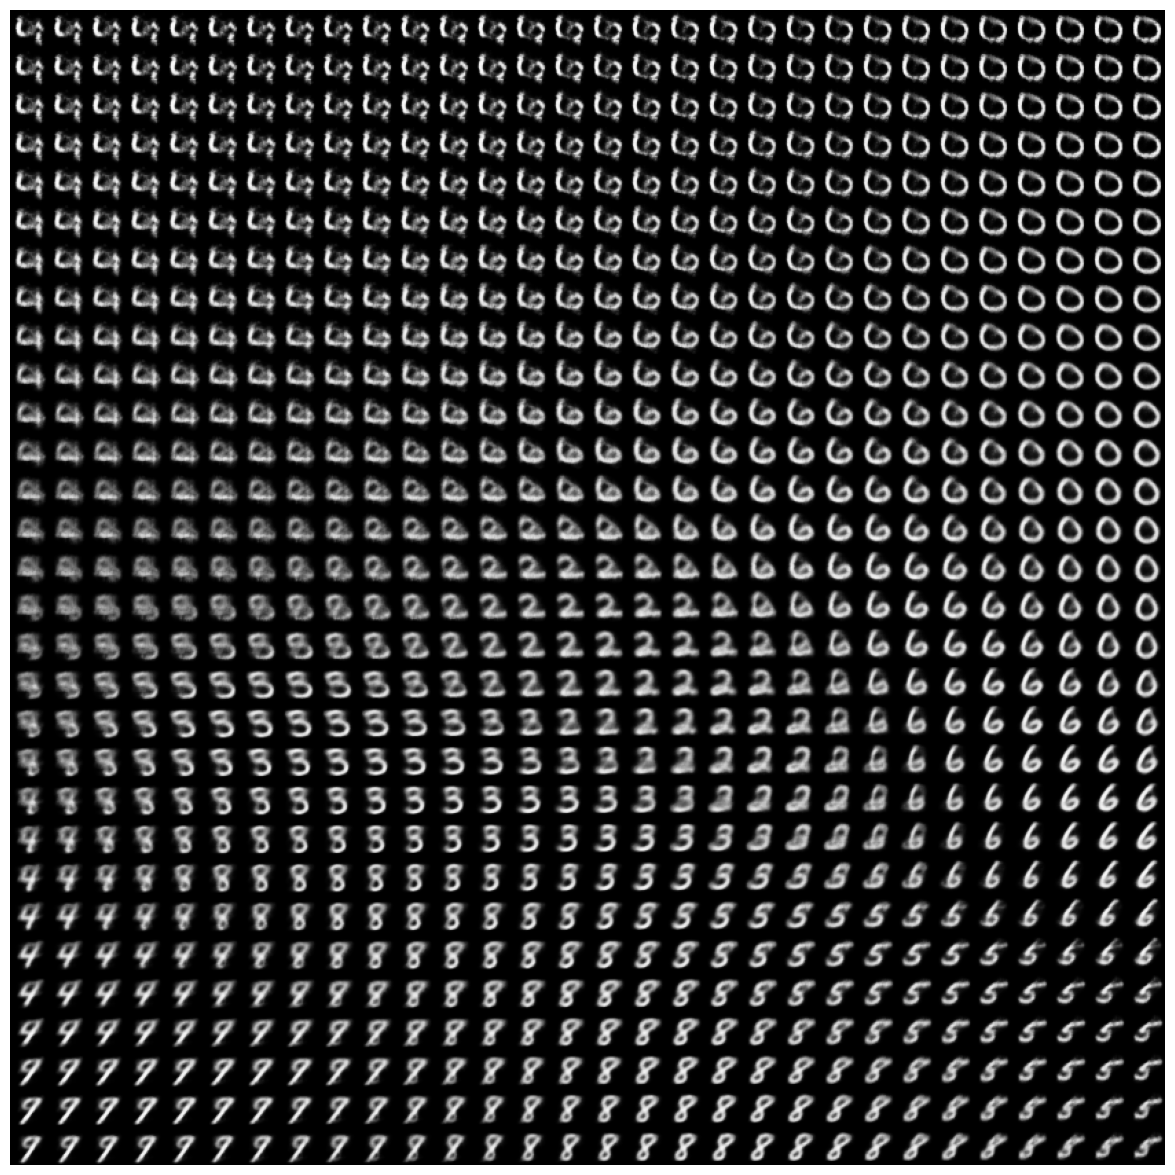

In [15]:
import matplotlib.pyplot as plt
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure [
            i * digit_size : (i +1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15,15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")